# Resilient Tube

In [1]:
from csv import reader
from igraph import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from random import choice

In [2]:
# Read local file and create edge list in tuple format 
df = pd.read_csv("Data/InputData_Edges.csv")
dfedge = df[['Station from', 'Station to', 'Name']]
tuples = [tuple(x) for x in dfedge.values]

In [3]:
# Create graph based on edge list from previous step
ptn = Graph.TupleList(tuples, directed=True, vertex_name_attr="name", edge_attrs="line")
ptn["name"] = "PTN London Underground"
ptn.summary()

'IGRAPH DN-- 280 731 -- PTN London Underground\n+ attr: name (g), name (v), line (e)'

In [4]:
# Add flooding risk probability to nodes
df2 = pd.read_csv("Data/InputData_Stations.csv")
floods = np.asarray(df2[['name','FloodRisk1000a']])
for station in floods:
    try:
        vs = ptn.vs.find(name=station[0])
        vs['FloodRisk1000a'] = station[1]
    except ValueError:
        print(station[0], ' - not found!')

list(ptn.vs)
# TODO correct station names for values not found

BANK / MONUMENT  - not found!
BROMLEY-BY-BOW  - not found!
EARL'S COURT  - not found!
EDGWARE ROAD (BAK)  - not found!
EDGWARE ROAD (CIR)  - not found!
HAMMERSMITH (DIS)  - not found!
HEATHROW TERMINAL 4  - not found!
HEATHROW TERMINAL 5  - not found!
HEATHROW TERMINALS 123  - not found!
HIGHBURY & ISLINGTON  - not found!
KING'S CROSS ST. PANCRAS  - not found!
QUEEN'S PARK  - not found!
REGENT'S PARK  - not found!
SHEPHERD'S BUSH (CEN)  - not found!
SHEPHERD'S BUSH MARKET  - not found!
ST. JAMES'S PARK  - not found!
ST. JOHN'S WOOD  - not found!
ST. PAUL'S  - not found!
WALTHAMSTOW CENTRAL  - not found!
WOOD LANE  - not found!


[igraph.Vertex(<igraph.Graph object at 0x1137fe408>, 0, {'name': 'HARROW & WEALDSTONE', 'FloodRisk1000a': 0.1364}),
 igraph.Vertex(<igraph.Graph object at 0x1137fe408>, 1, {'name': 'KENTON', 'FloodRisk1000a': 0.1935}),
 igraph.Vertex(<igraph.Graph object at 0x1137fe408>, 2, {'name': 'SOUTH KENTON', 'FloodRisk1000a': 0.4833}),
 igraph.Vertex(<igraph.Graph object at 0x1137fe408>, 3, {'name': 'NORTH WEMBLEY', 'FloodRisk1000a': 0.2384}),
 igraph.Vertex(<igraph.Graph object at 0x1137fe408>, 4, {'name': 'WEMBLEY CENTRAL', 'FloodRisk1000a': 0.0472}),
 igraph.Vertex(<igraph.Graph object at 0x1137fe408>, 5, {'name': 'STONEBRIDGE PARK', 'FloodRisk1000a': 0.2317}),
 igraph.Vertex(<igraph.Graph object at 0x1137fe408>, 6, {'name': 'HARLESDEN', 'FloodRisk1000a': 0.124}),
 igraph.Vertex(<igraph.Graph object at 0x1137fe408>, 7, {'name': 'WILLESDEN JUNCTION', 'FloodRisk1000a': 0.205}),
 igraph.Vertex(<igraph.Graph object at 0x1137fe408>, 8, {'name': 'KENSAL GREEN', 'FloodRisk1000a': 0.0771}),
 igraph.V

In [5]:
# Add betweeness centrality to vertices
# for vertex in ptn.vs:
#     vertex["betw_cent"] = ptn.betweenness(vertex, directed=True)

**Create target list by floooding**

In [6]:
# Process used during dacas meeting, will be replaced by vertex probaility
df3 = pd.read_csv("Data/InputData_Stations.csv")
flood = df3[['name','FloodRisk1000a']]
threshold = flood['name'][flood.FloodRisk1000a > 0.3]
targets = []

for i in threshold:
    targets.append(i)

ptn2 = ptn
targets

['BARONS COURT',
 'BOND STREET',
 'BURNT OAK',
 'KENSINGTON (OLYMPIA)',
 'LANCASTER GATE',
 'MOOR PARK',
 'NEASDEN',
 'SOUTH KENTON',
 'THEYDON BOIS',
 'WESTBOURNE PARK']

In [7]:
# Proting function

def plot_hist(tup, target):
    sns.set(context="notebook", font_scale=1.2)
    plt.figure(facecolor="white", figsize=(9, 6), dpi=300)
    plt.xlabel('Path Length')
    plt.ylabel('Frequency')
    plt.title('Path Length distribution station: %s' % str(target))
    plt.bar(*zip(*tup))

**Delete nodes based on Flood Risk**

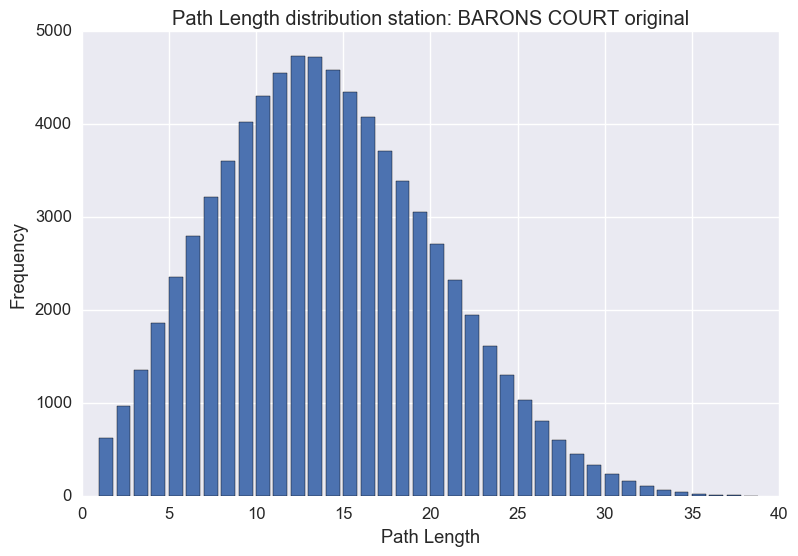

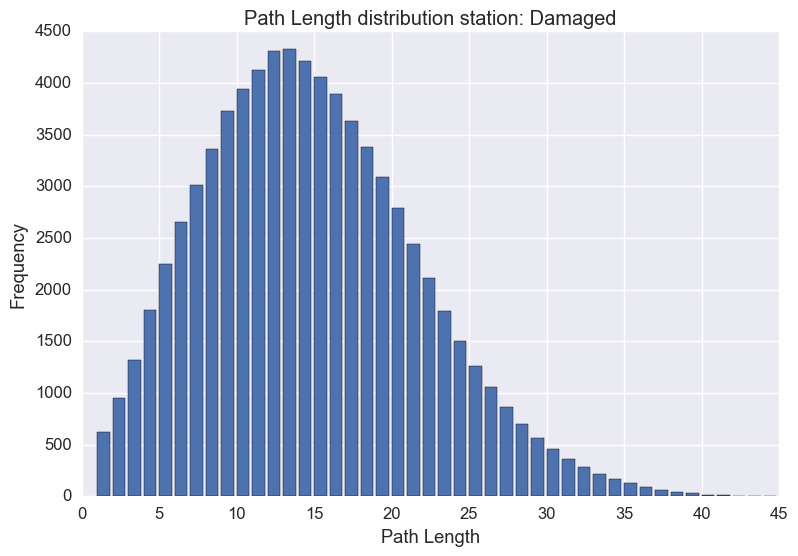

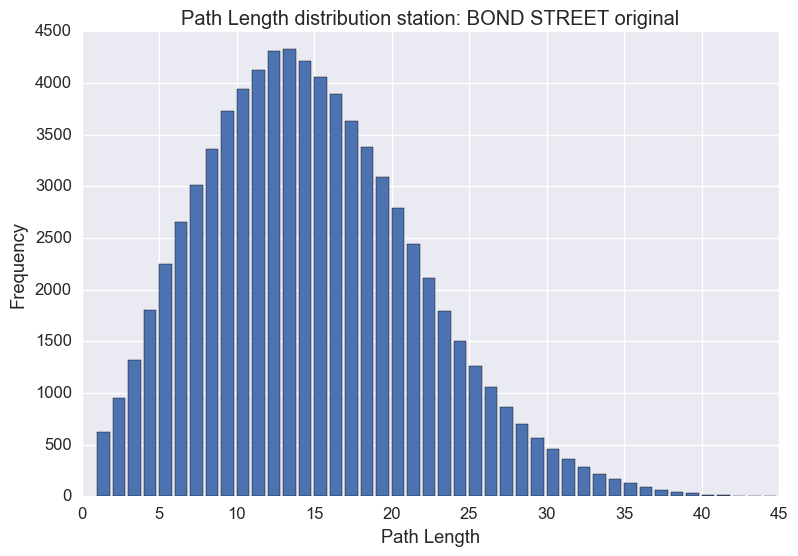

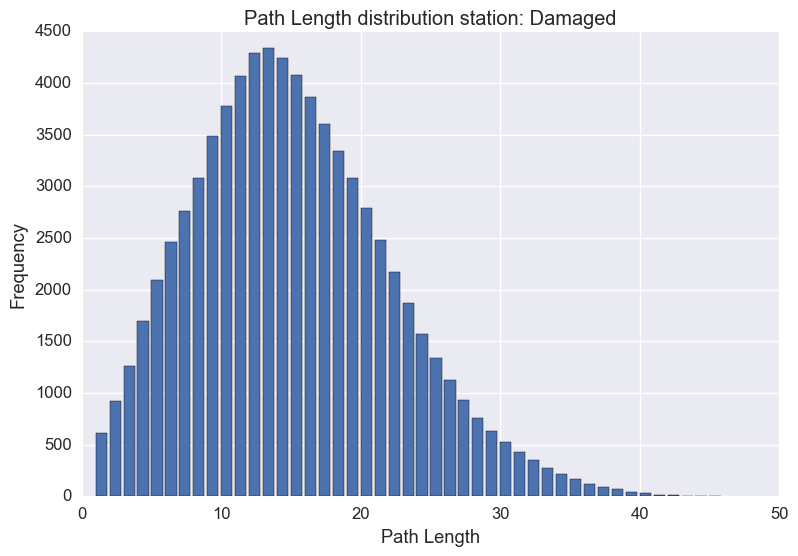

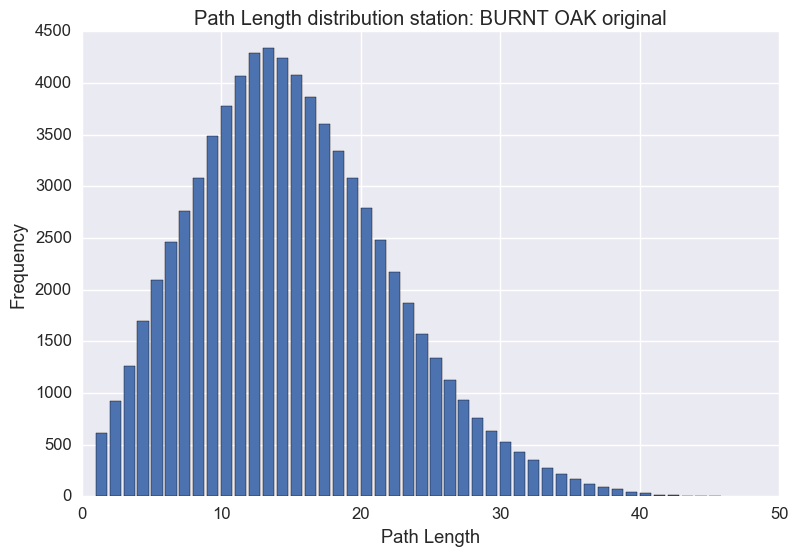

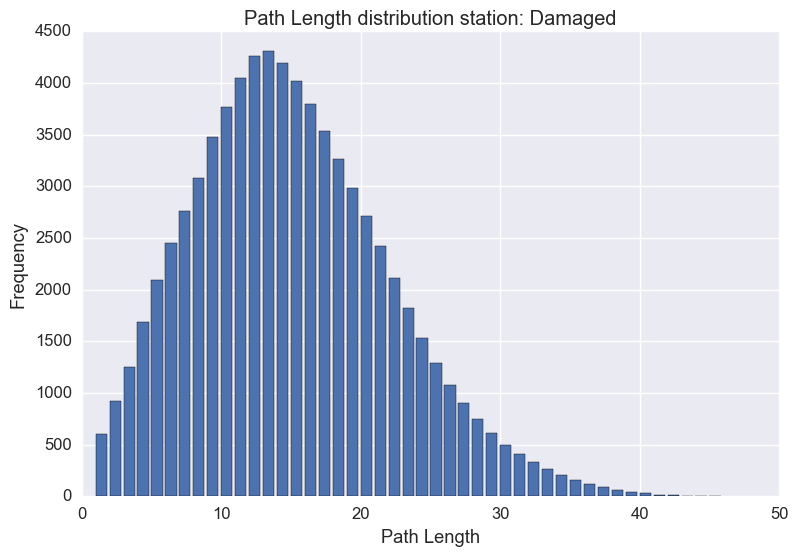

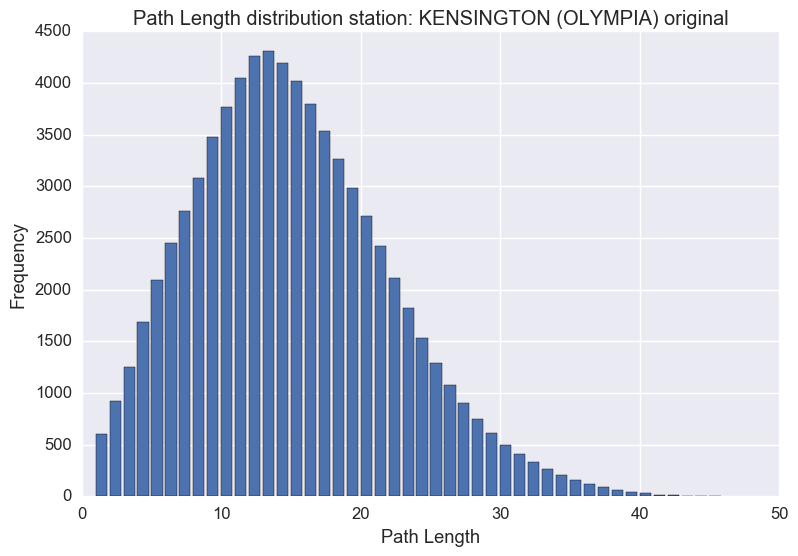

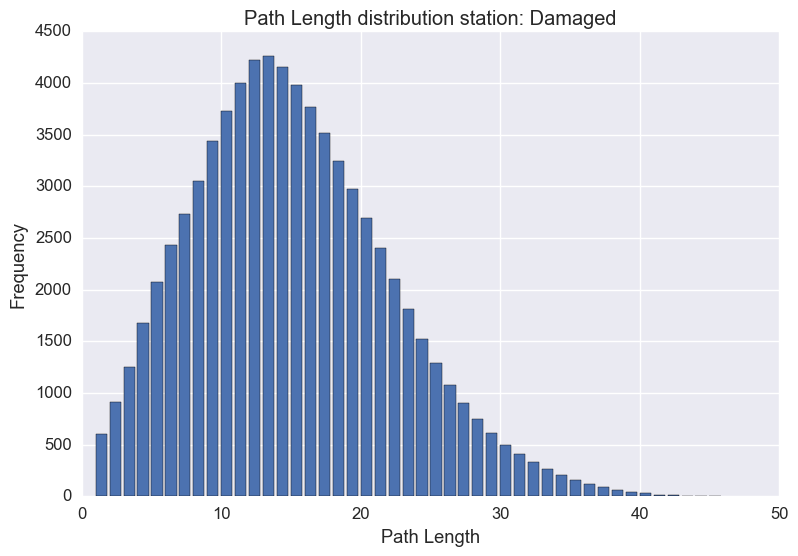

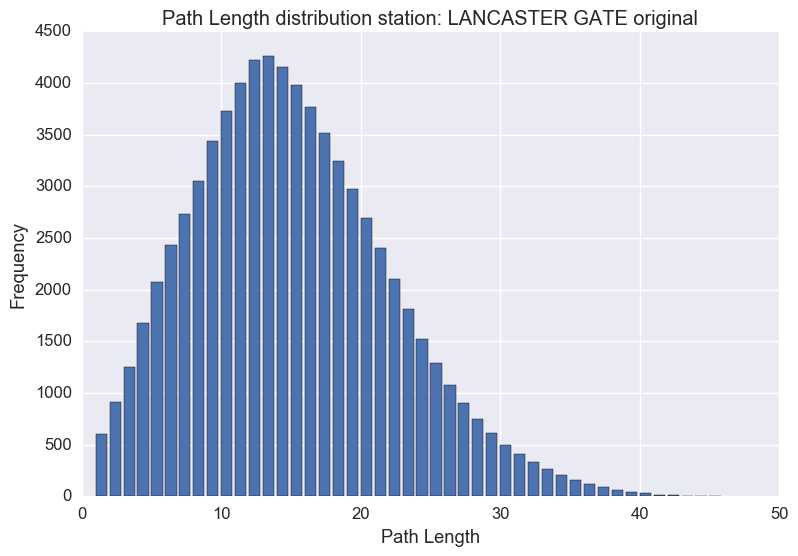

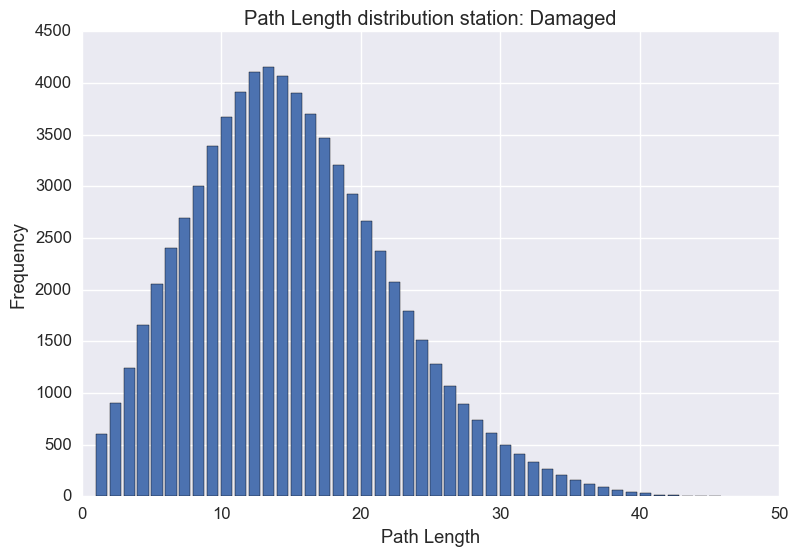

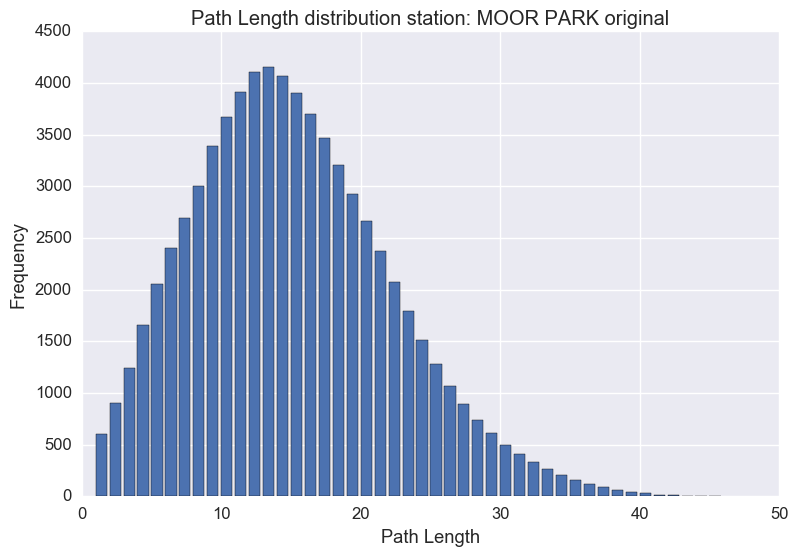

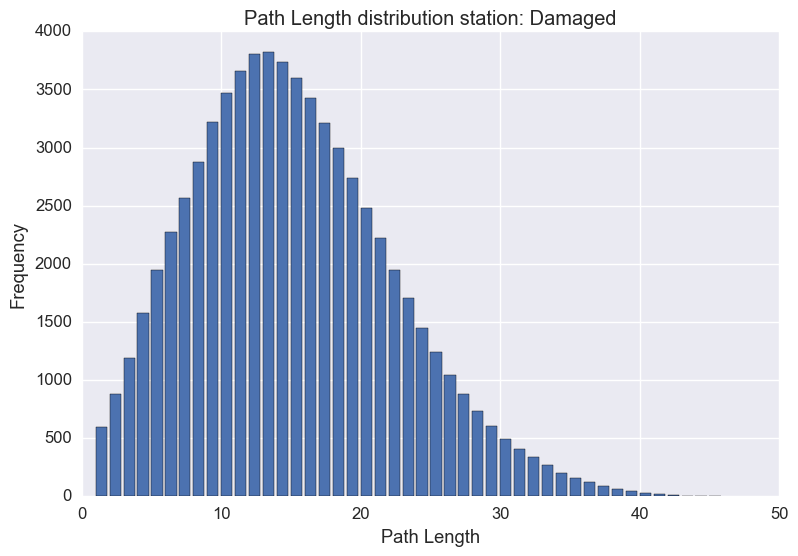

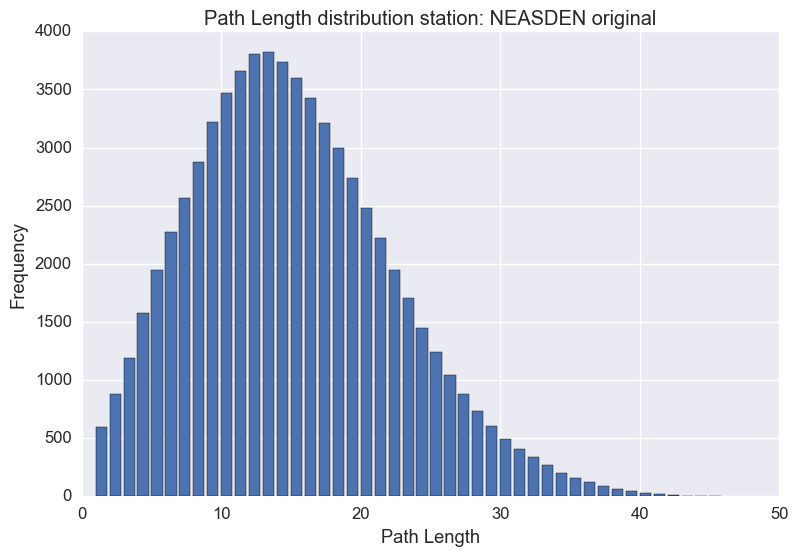

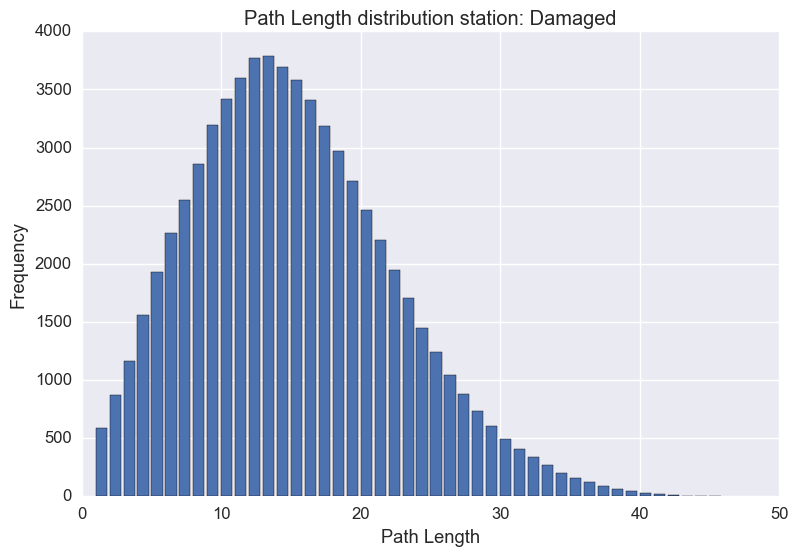

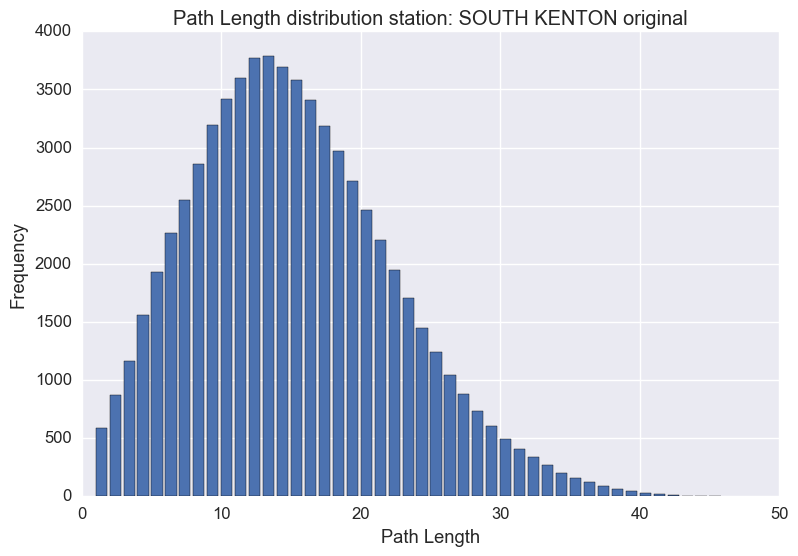

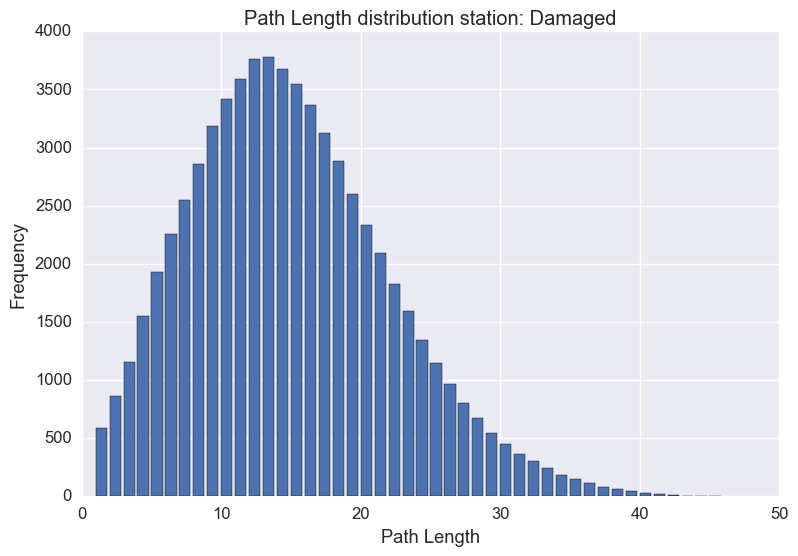

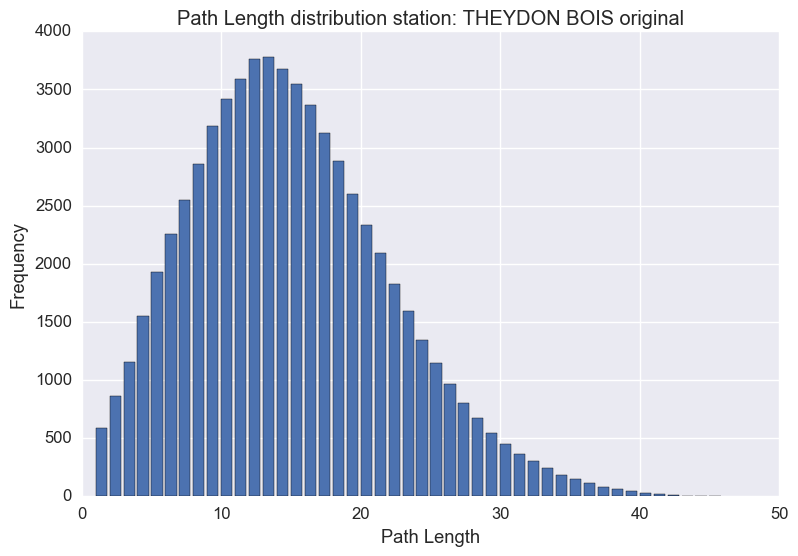

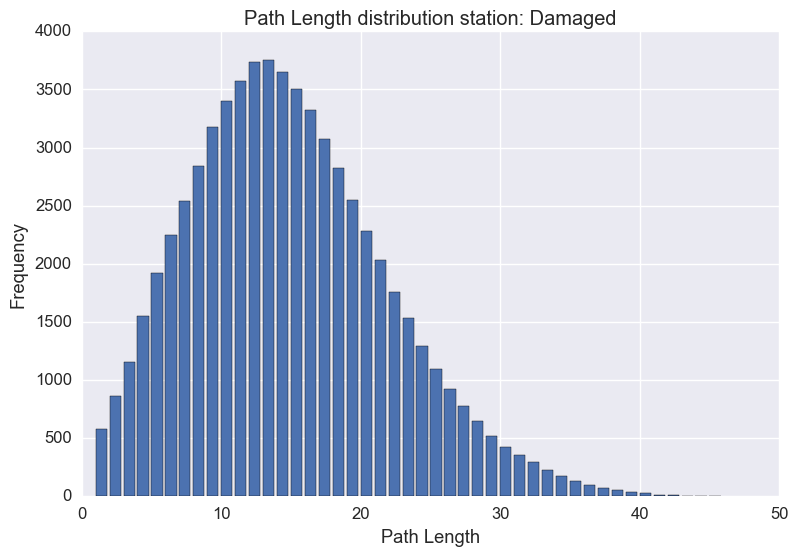

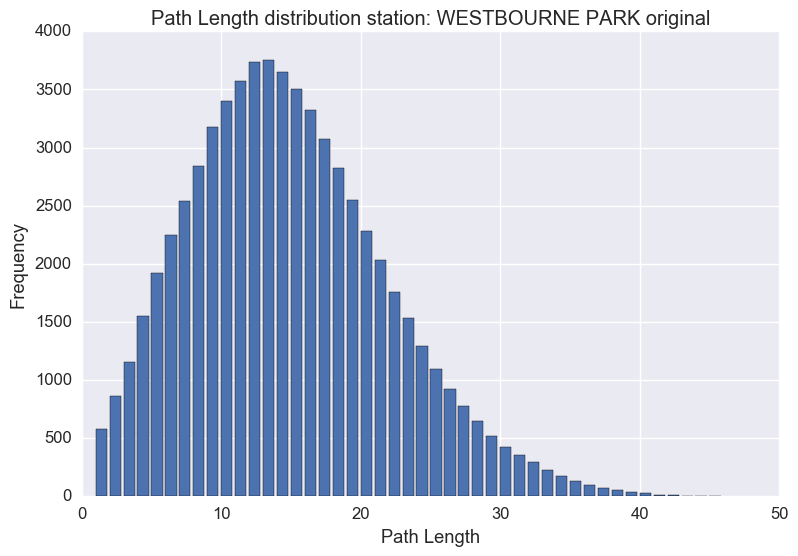

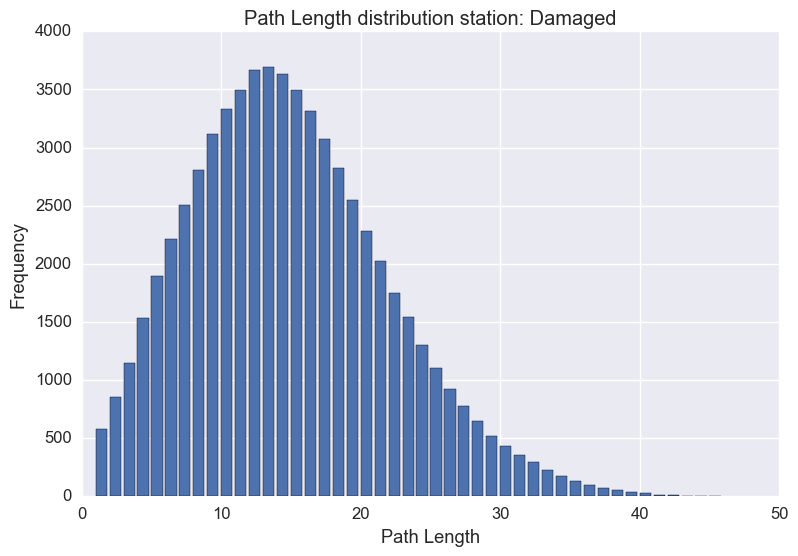

In [8]:
% matplotlib inline

for i in targets:
    path_hist_orig = list(ptn.path_length_hist(directed=True).bins())
    hist_orig = []
    for bin1 in path_hist_orig:
        x1 = bin1[0]
        y1 = bin1[2]
        hist_orig.append((x1,y1))
    plot_hist(hist_orig, i + str(' original'))

    ptn.delete_vertices(ptn.vs.find(name=i))
    path_hist_dell = list(ptn.path_length_hist(directed=True).bins())
    hist_dell = []
    for bin2 in path_hist_dell:
        x2 = bin2[0]
        y2 = bin2[2]
        hist_dell.append((x2,y2))
    
    plot_hist(hist_dell, 'Damaged')

**Delete nodes based on Betweeness Centrality**

In [ ]:
% matplotlib inline

count = 0

while count <= 10:
    max_bc = max(ptn2.vs['beetw_cent'])
    target = ptn2.vs(ptn2.vs['beetw_cent'] == max_bc)['name']
    
    path_hist_orig = list(ptn2.path_length_hist(directed=True).bins())
    hist_orig = []
    for bin1 in path_hist_orig:
        x1 = bin1[0]
        y1 = bin1[2]
        hist_orig.append((x1,y1))
    plot_hist(hist_orig, i + str(' original'))

    ptn2.delete_vertices(ptn2.vs.find(name=i))
    path_hist_dell = list(ptn2.path_length_hist(directed=True).bins())
    hist_dell = []
    for bin2 in path_hist_dell:
        x2 = bin2[0]
        y2 = bin2[2]
        hist_dell.append((x2,y2))
    plot_hist(hist_dell, 'Damaged')
    
    count += 1

In [ ]:
# Ploting function
# % matplotlibe inline
# layout = ptn.layout_kamada_kawai()
# plot(ptn, layout = layout)